SOK-3011 - Finans

## Importerer data fra Titlon

In [12]:


import pandas as pd
#Query script for Microsoft SQL Server (MSSQL) client
import pymssql
con = pymssql.connect(host='titlon.uit.no', 
                    user="esi000@uit.no", 
                    password="GTJQ9HZXqR4!$5$NuMR8E", 
                    database='OSE')  
crsr=con.cursor()
crsr.execute("""
	SELECT  * FROM [OSE].[dbo].[equity] 
	WHERE year([Date]) >= 2016
	ORDER BY [Name],[Date]
""")
r=crsr.fetchall()
df=pd.DataFrame(list(r), columns=[i[0] for i in crsr.description])
df



#YOU NEED TO BE CONNECTED TO YOUR INSTITUTION VIA VPN, OR BE AT THE INSTITUTION, FOR THIS CODE TO WORK

,Date,Internal code,SecurityId,CompanyId,Symbol,ISIN,Name,BestBidPrice,BestAskPrice,Open,...,NOWA_DayLnrate,bills_3month_Lnrate,Sector,IN_OSEBX,Equity,Debt,Earnings,debt_ratio,PE,ID
0,2019-07-12,2014128.0,1304857.0,12720.0,2020,BMG9156K1018,2020 Bulkers,82.05,83.00,87.20,...,0.000056,0.000056,Industrials,0,NaN,NaN,NaN,NaN,NaN,1402537
1,2019-07-15,2014128.0,1304857.0,12720.0,2020,BMG9156K1018,2020 Bulkers,80.05,81.00,83.00,...,0.000055,0.000056,Industrials,0,NaN,NaN,NaN,NaN,NaN,1402664
2,2019-07-16,2014128.0,1304857.0,12720.0,2020,BMG9156K1018,2020 Bulkers,80.55,81.00,81.00,...,0.000055,0.000056,Industrials,0,NaN,NaN,NaN,NaN,NaN,1402784
3,2019-07-17,2014128.0,1304857.0,12720.0,2020,BMG9156K1018,2020 Bulkers,80.40,81.00,81.00,...,0.000055,0.000056,Industrials,0,NaN,NaN,NaN,NaN,NaN,1413127
4,2019-07-18,2014128.0,1304857.0,12720.0,2020,BMG9156K1018,2020 Bulkers,77.40,80.00,80.01,...,0.000056,0.000057,Industrials,0,NaN,NaN,NaN,NaN,NaN,1413224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546507,2024-03-27,2014095.0,NaN,NaN,AASB,NO0010672181,AASEN SPAREBANK,121.00,118.00,121.00,...,0.000196,0.000191,Financials,0,NaN,NaN,NaN,NaN,NaN,1767510
546508,2024-03-28,2014095.0,NaN,NaN,AASB,NO0010672181,AASEN SPAREBANK,123.00,118.00,0.00,...,0.000196,0.000191,Financials,0,NaN,NaN,NaN,NaN,NaN,1774640
546509,2024-04-02,2014095.0,NaN,NaN,AASB,NO0010672181,AASEN SPAREBANK,119.00,118.30,121.00,...,0.000196,0.000192,Financials,0,NaN,NaN,NaN,NaN,NaN,1774810
546510,2024-04-03,2014095.0,NaN,NaN,AASB,NO0010672181,AASEN SPAREBANK,123.00,119.00,119.00,...,0.000196,0.000192,Financials,0,NaN,NaN,NaN,NaN,NaN,1767992


## Definerer noen variabler

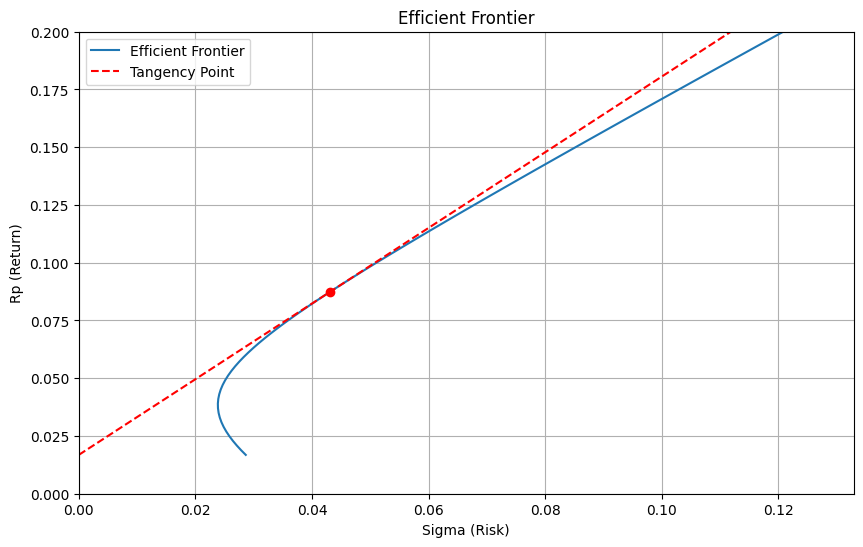

In [23]:
import functions
import decomposition
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


MAX_AXIS = 0.2

df = pd.read_pickle('output/output.df')
# Defining risk free, cov matrix and mean vector
rf = np.exp(0.2/12)-1#df['NOWA_DayLnrate'].mean()

cov_matrix, means = functions.calc_moments(df, False)
R = decomposition.get_independent_portfolios(cov_matrix, 0.00001)
cov_matrix = R.T @ cov_matrix @ R
means = R.T @ means
# Create a vector of ones with the same length as the number of columns in the covariance matrix
ones = np.ones(cov_matrix.shape[0])

# Some useful scalar values
A = np.dot(ones.T, np.dot(np.linalg.inv(cov_matrix), ones))
B = np.dot(ones.T, np.dot(np.linalg.inv(cov_matrix), means-rf))
C = np.dot(means.T-rf, np.dot(np.linalg.inv(cov_matrix), means-rf))

#Creating plot
fig, ax = plt.subplots(figsize=(10, 6))

# Setting the range of rp values and sigma values
rp_values = np.linspace(0, MAX_AXIS, 100)


# Calculate and plot sigma values for each rp
sigma_values = 1/A + ((rp_values - abs(B)/A)**2) / (C - B**2/A)
ax.plot(sigma_values**0.5, rp_values+rf, label='Efficient Frontier')

# Calculate the tangency point and tangent
tangency_rp = C/abs(B)
tangency_sigma =  1/A + ((tangency_rp - abs(B)/A)**2) / (C - B**2/A)

ax.plot(tangency_sigma**0.5, tangency_rp + rf, 'ro')
sigma_range = np.linspace(0, np.max(sigma_values**0.5), 100)
ax.plot(sigma_range, rf + sigma_range*tangency_rp/tangency_sigma**0.5, color='r', linestyle='--', label='Tangency Point')
ax.set_xlim([0, np.max(sigma_values**0.5)])
ax.set_ylim([0, np.max(rp_values)])
ax.set_xlabel('Sigma (Risk)')
ax.set_ylabel('Rp (Return)')
ax.set_title('Efficient Frontier')
ax.grid(True)
ax.legend()

In [17]:
np.array(cov_matrix*10000, dtype=int)



array([[   65,     0,     0, ...,     0,     0,     0],
       [    0,    92,     0, ...,     0,     0,     0],
       [    0,     0,  1331, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ..., 80328,     0,     0],
       [    0,     0,     0, ...,     0,  1870,     0],
       [    0,     0,     0, ...,     0,     0,   165]])

In [9]:
import numpy as np
X = np.random.randint()
Y = np.array(
    [int(np.rand()*100) for i in np.arange(2)] for j in np.arange(3)
)

print(X)

<generator object <genexpr> at 0x10b3eb450>


In [13]:
np.random.randint(0,100,(2,3))

array([[94, 83, 70],
       [70, 34, 69]])

In [ ]:
result = np.dot(X, Y)
result